<a href="https://colab.research.google.com/github/Zesmat/Market-Price-Prediction/blob/main/Market_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocessing**

## **Load Data**

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score



data=pd.read_csv(r'/content/drive/MyDrive/Market Price Prediction/MarketPricePrediction.csv')
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set the date as the index
print(data.shape)
data.head()

(10227, 10)


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,2005-01-01
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,2006-01-01
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,2012-01-01


## **Encoding Values**

In [ ]:
label_encoder_city = LabelEncoder()
data['city'] = label_encoder_city.fit_transform(data['city'])

label_encoder_state = LabelEncoder()
data['state'] = label_encoder_state.fit_transform(data['state'])

label_encoder_market = LabelEncoder()
data['market'] = label_encoder_state.fit_transform(data['market'])
label_encoder_month = LabelEncoder()
data['month'] = label_encoder_state.fit_transform(data['month'])


In [ ]:
data = pd.get_dummies(data, columns=['market', 'state', 'city', 'month'])
print(data.columns)


Index(['year', 'quantity', 'priceMin', 'priceMax', 'priceMod', 'date',
       'market_ABOHAR(PB)', 'market_AGRA(UP)', 'market_AHMEDABAD(GUJ)',
       'market_AHMEDNAGAR(MS)',
       ...
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September'],
      dtype='object', length=276)


Cheki

In [ ]:
data.fillna(method='ffill', inplace=True)
data = data.sort_values(by='date')

# Check for missing values
print(data.isnull().sum())



In [ ]:
# Create lagged features
for lag in range(1, 13):
    data[f'quantity_lag_{lag}'] = data['quantity'].shift(lag)


# Create rolling statistics
data['rolling_mean_3'] = data['quantity'].rolling(window=3).mean()
data['rolling_std_3'] = data['quantity'].rolling(window=3).std()

# Check if the data DataFrame is empty

if data.empty:
    raise ValueError("Dataframe is empty. Cannot proceed.")

# Drop NA values created by lagging and rolling
data.dropna(inplace=True)

# Select features and target
features = ['priceMax', 'priceMin', 'priceMod', 'month', 'city', 'state', 'market'] + [f'quantity_lag_{lag}' for lag in range(1, 13)]
target = data['quantity']

# **Exploratory Data Analysis**

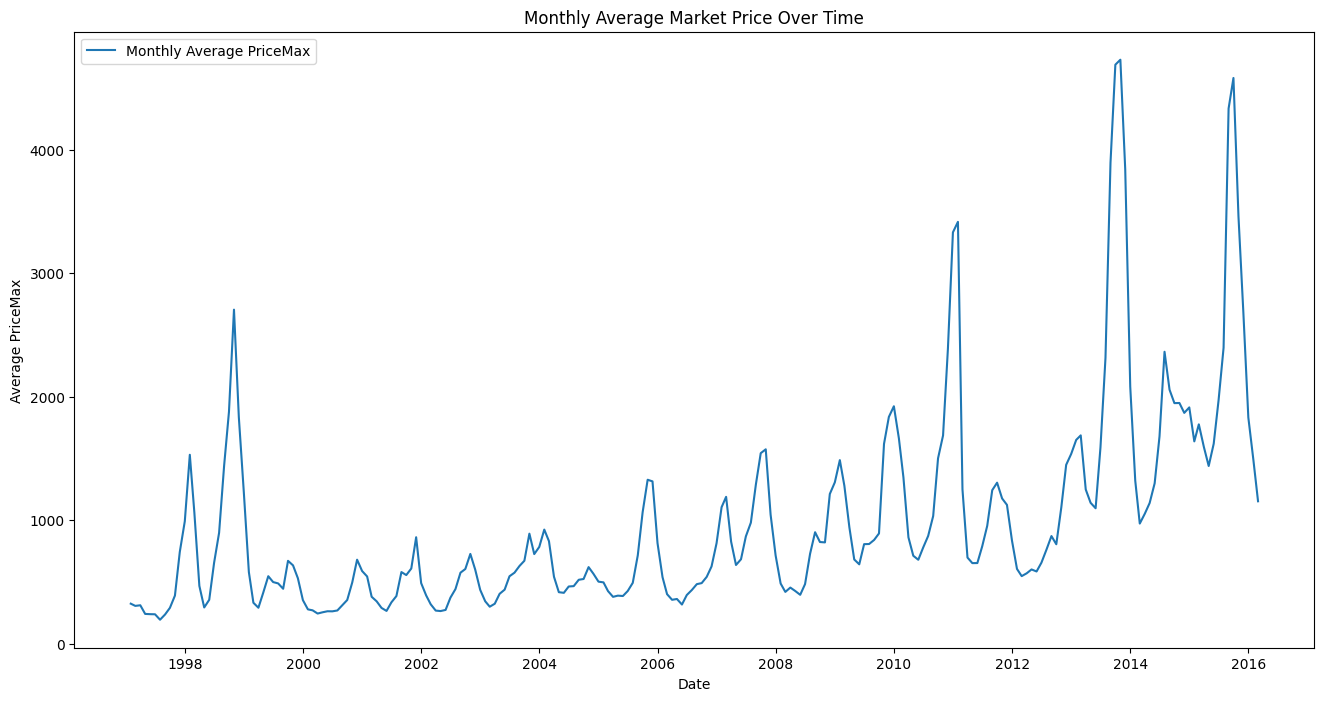

        market    month     year   quantity  priceMin  priceMax  priceMod  \
count 10215.00 10215.00 10215.00   10215.00  10215.00  10215.00  10215.00   
mean     61.70     5.48  2009.04   76483.36    647.51   1213.75    985.07   
std      33.57     3.44     4.35  124423.43    673.31    979.80    818.63   
min       0.00     0.00  1997.00      20.00     16.00    145.00     80.00   
25%      36.00     3.00  2006.00    8875.00    210.00    558.00    449.00   
50%      64.00     5.00  2009.00   27400.00    441.00    924.00    747.00   
75%      90.00     8.00  2013.00   87883.50    829.00   1528.00   1250.00   
max     119.00    11.00  2016.00 1639032.00   6000.00   8192.00   6400.00   

         state     city  quantity_lag_1  ...  quantity_lag_5  quantity_lag_6  \
count 10215.00 10215.00        10215.00  ...        10215.00        10215.00   
mean     12.54    59.56        76490.47  ...        76499.65        76512.96   
std       4.73    32.53       124430.74  ...       124420.80      

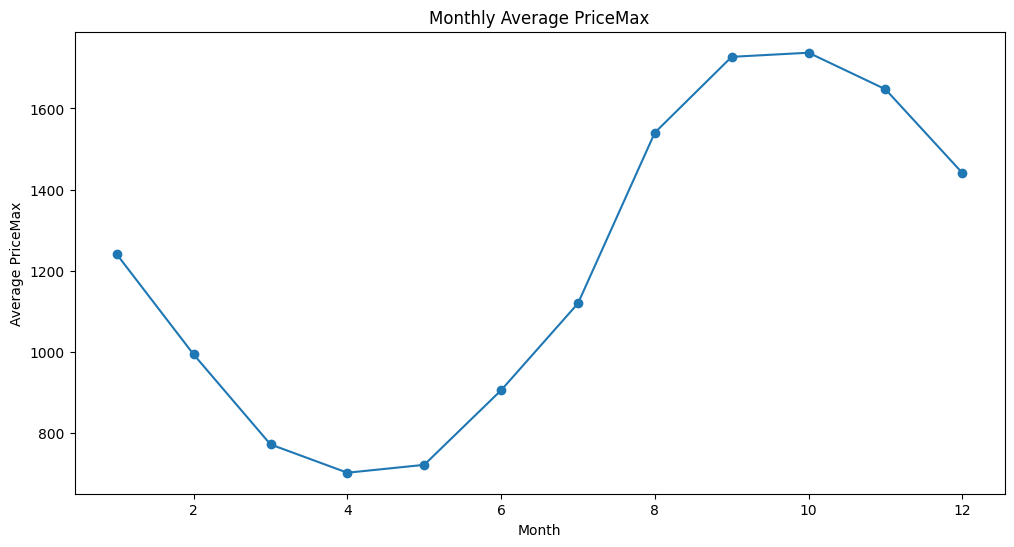

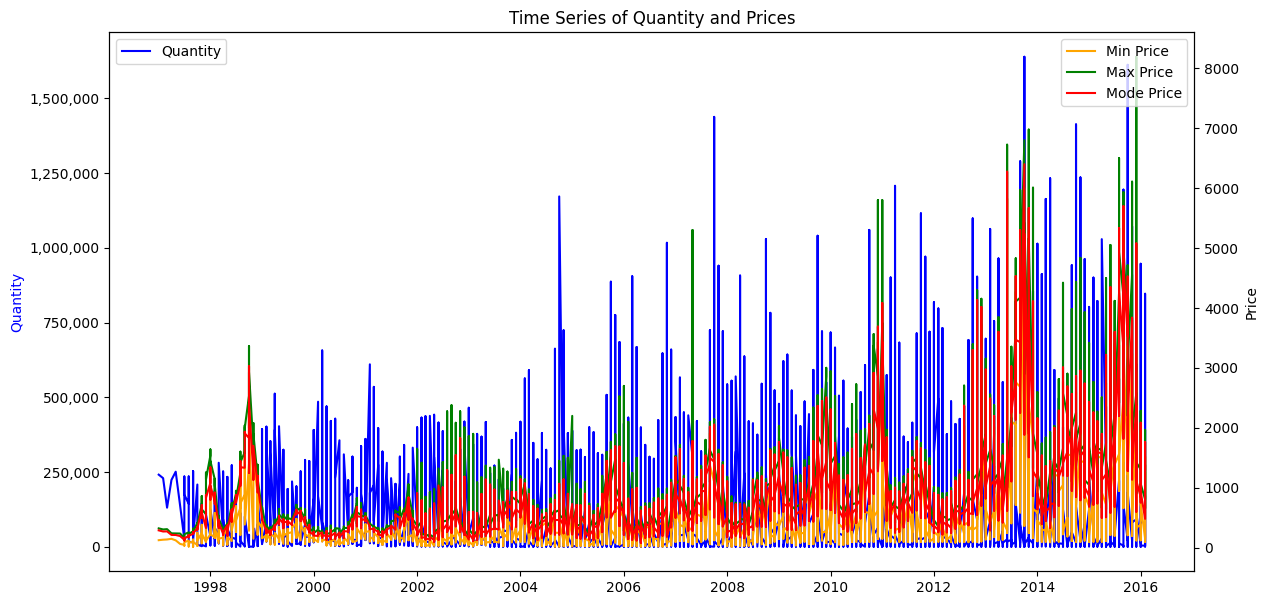

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Convert 'date' to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Aggregate the data by month and calculate the mean priceMax for each month
monthly_avg = data['priceMax'].resample('M').mean()

# Plot the monthly average priceMax
plt.figure(figsize=(16, 8))
plt.plot(monthly_avg, label='Monthly Average PriceMax')
plt.xlabel('Date')
plt.ylabel('Average PriceMax')
plt.title('Monthly Average Market Price Over Time')
plt.legend()
plt.show()

# Display summary statistics
print(data.describe())

# Check for seasonality and trends
data['year'] = data.index.year
data['month'] = data.index.month

monthly_avg = data.groupby('month')['priceMax'].mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg, marker='o')
plt.title('Monthly Average PriceMax')
plt.xlabel('Month')
plt.ylabel('Average PriceMax')
plt.show()

# Plot the time series for quantity and prices
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot quantity on primary y-axis
ax1.plot(data.index, data['quantity'], color='blue', label='Quantity')
ax1.set_ylabel('Quantity', color='blue')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Create a secondary y-axis for prices
ax2 = ax1.twinx()
ax2.plot(data.index, data['priceMin'], color='orange', label='Min Price')
ax2.plot(data.index, data['priceMax'], color='green', label='Max Price')
ax2.plot(data.index, data['priceMod'], color='red', label='Mode Price')
ax2.set_ylabel('Price', color='black')

# Show legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Time Series of Quantity and Prices')
plt.show()


In [ ]:
!pip install --upgrade matplotlib

## **Seasonal Decomposition**

<Figure size 1500x700 with 0 Axes>

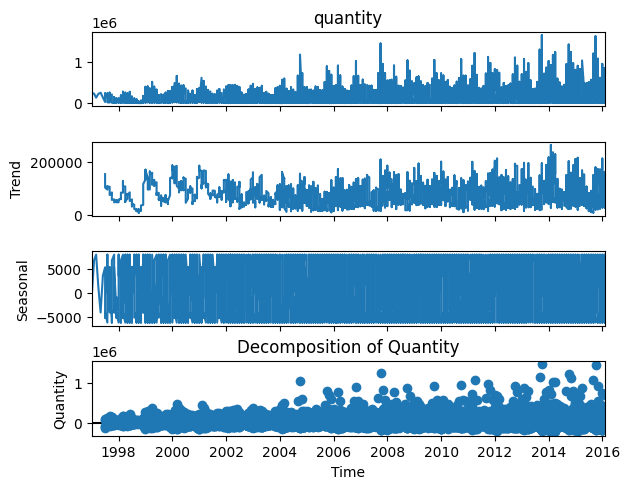

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series (for example on quantity)
decomposition = seasonal_decompose(data['quantity'], model='additive', period=12)
plt.figure(figsize=(15, 7))
decomposition.plot()
plt.xlabel("Time")
plt.ylabel("Quantity")
plt.title("Decomposition of Quantity")
plt.show()

# **Model Building**

## **Data Scaler**

In [ ]:
#Drop rows with NaN values created by shifting
data.dropna(inplace=True)



# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(data[features])
scaled_data=pd.DataFrame(features_scaled, columns=features)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape and scale the data in a single step
scaled_data = scaler.fit_transform(np.array(data[features]).reshape(-1, len(features)))

# Verify the shape of the scaled data
print("Shape of scaled data:", scaled_data.shape)

## **Splitting Data**

In [ ]:
# Split the data into training and testing sets
# Splitting dataset into training and testing
training_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - training_size

train_data = scaled_data[0:training_size]
test_data = scaled_data[training_size:len(scaled_data)]

train_target = target[0:training_size].values
test_target = target[training_size:len(target)].values


# Verify the shapes of the resulting splits
print("Train Data Shape:", train_data.shape)
print("Train Target Shape:", train_target.shape)
print("Test Data Shape:", test_data.shape)
print("Test Target Shape:", test_target.shape)

# Print first few rows of train and test data
print("Train Data Sample:")
print(train_data[:5])
print("Train Target Sample:")
print(train_target[:5])
print("Test Data Sample:")
print(test_data[:5])
print("Test Target Sample:")
print(test_target[:5])

NameError: name 'scaled_data' is not defined

## **Pre-modeling LSTM**

In [ ]:
# Define the sequence length

# Function to create sequences for LSTM
def create_sequences(data,target,sequence_length=1):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length-1):
        s=data[i:i + sequence_length, 0]
        sequences.append(s)
        targets.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(targets)


sequence_length = 100
# Prepare the training and testing data
X_train_seq, y_train_seq = create_sequences(train_data,train_target, sequence_length)
X_test_seq, y_test_seq = create_sequences(test_data,test_target, sequence_length)
# Reshape the input data for LSTM
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1],1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1],1)


# Verify the shapes of the sequences
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")


In [ ]:
X_train_seq,train_target

(array([[[0.02212004],
         [0.01988319],
         [0.02050454],
         ...,
         [0.13731826],
         [0.16652169],
         [0.16329067]],
 
        [[0.01988319],
         [0.02050454],
         [0.01180564],
         ...,
         [0.16652169],
         [0.16329067],
         [0.1644091 ]],
 
        [[0.02050454],
         [0.01180564],
         [0.0115571 ],
         ...,
         [0.16329067],
         [0.1644091 ],
         [0.16378775]],
 
        ...,
 
        [[0.57760656],
         [0.48030322],
         [0.62582329],
         ...,
         [0.29551386],
         [0.25077669],
         [0.1912514 ]],
 
        [[0.48030322],
         [0.62582329],
         [0.76438424],
         ...,
         [0.25077669],
         [0.1912514 ],
         [0.22219461]],
 
        [[0.62582329],
         [0.76438424],
         [0.57959488],
         ...,
         [0.1912514 ],
         [0.22219461],
         [0.2015658 ]]]),
 array([241225, 229550, 130885, ...,  12020,  81900,  2

In [ ]:
pip install tensorflow==2.15.0


In [ ]:
pip install tensorflow==2.10.0

## **LSTM**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define a function to create the model
# Define a function to create the model
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
#prevents overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Build the model
history=model.fit(X_train_seq, y_train_seq,validation_data=(X_test_seq, y_test_seq),epochs=10,batch_size=32,verbose=1,validation_split=0.2,callbacks=[early_stopping])





NameError: name 'sequence_length' is not defined

## **Prediction**

61/61 [==============================] - 3s 50ms/step
Training Metrics:
MAE: 0.021603992299289408
MSE: 0.0013893359413119431
RMSE: 0.037273796980076275
R^2: 0.8736539448714882
Testing Metrics:
MAE: 0.04209968732380633
MSE: 0.003975918458027517
RMSE: 0.06305488448984359
R^2: 0.7663943330173015


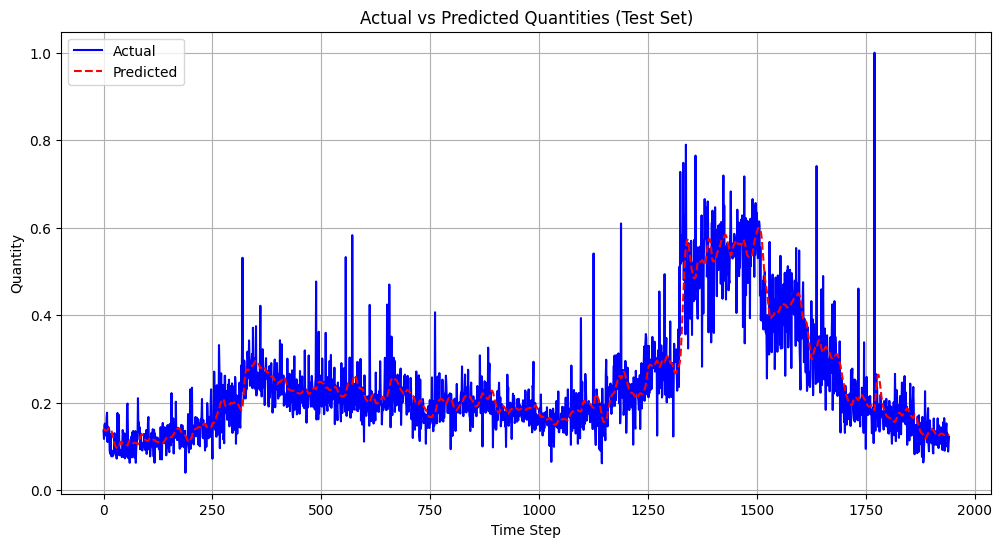

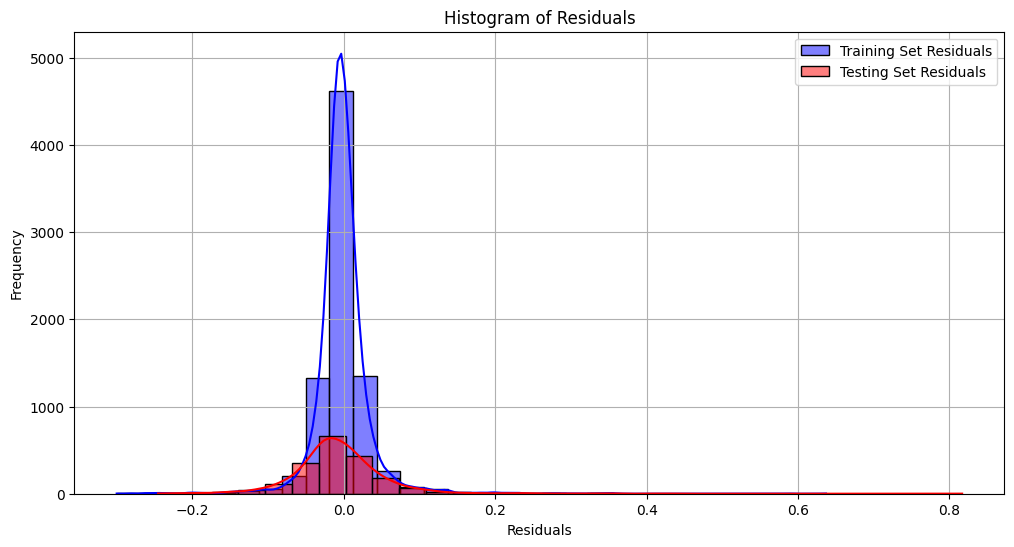

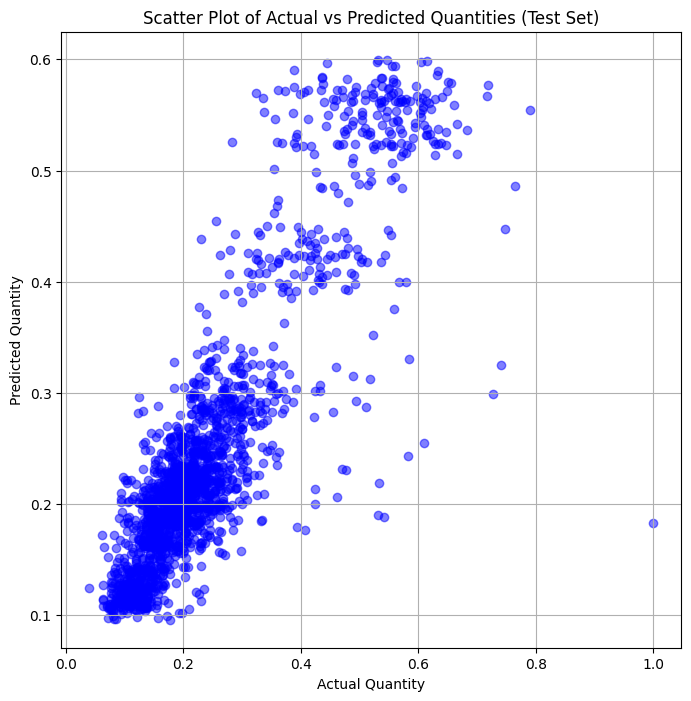

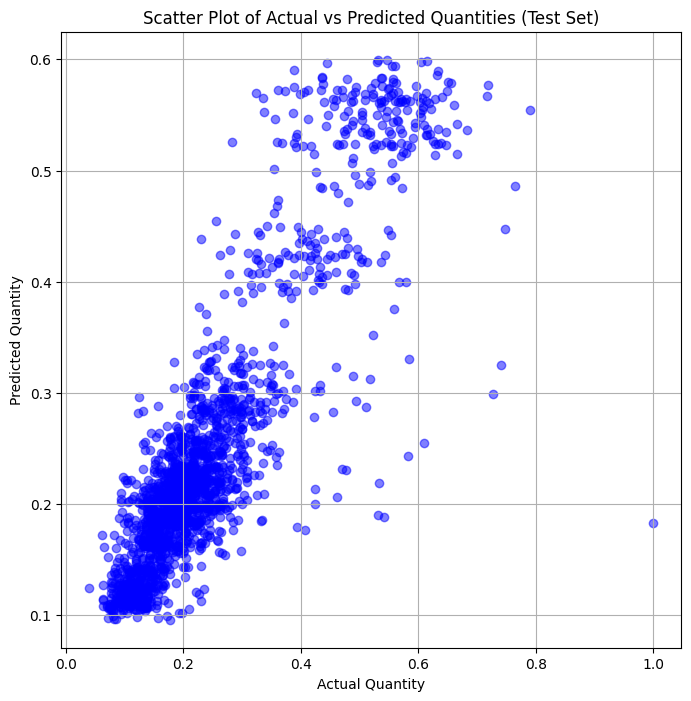

In [ ]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Make predictions
train_predict = model.predict(X_train_seq)
test_predict = model.predict(X_test_seq)

# Evaluate the model
train_mae = mean_absolute_error(y_train_seq, train_predict)
train_mse = mean_squared_error(y_train_seq, train_predict)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_seq, train_predict)

test_mae = mean_absolute_error(y_test_seq, test_predict)
test_mse = mean_squared_error(y_test_seq, test_predict)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_seq, test_predict)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_rmse}")
print(f"R^2: {train_r2}")

print("Testing Metrics:")
print(f"MAE: {test_mae}")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_rmse}")
print(f"R^2: {test_r2}")



import seaborn as sns

# Plot actual vs predicted quantities for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(test_predict, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Quantities (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals
residuals_train = y_train_seq - train_predict.flatten()
residuals_test = y_test_seq - test_predict.flatten()

# Plot histograms of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals_train, bins=30, kde=True, color='blue', label='Training Set Residuals')
sns.histplot(residuals_test, bins=30, kde=True, color='red', label='Testing Set Residuals')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of actual vs predicted quantities for test set
plt.figure(figsize=(8, 8))
plt.scatter(y_test_seq, test_predict, color='blue', alpha=0.5)
plt.title('Scatter Plot of Actual vs Predicted Quantities (Test Set)')
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.grid(True)
plt.show()


# Scatter plot of actual vs predicted quantities for test set
plt.figure(figsize=(8, 8))
plt.scatter(y_test_seq, test_predict, color='blue', alpha=0.5)
plt.title('Scatter Plot of Actual vs Predicted Quantities (Test Set)')
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.grid(True)
plt.show()


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_6 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trai

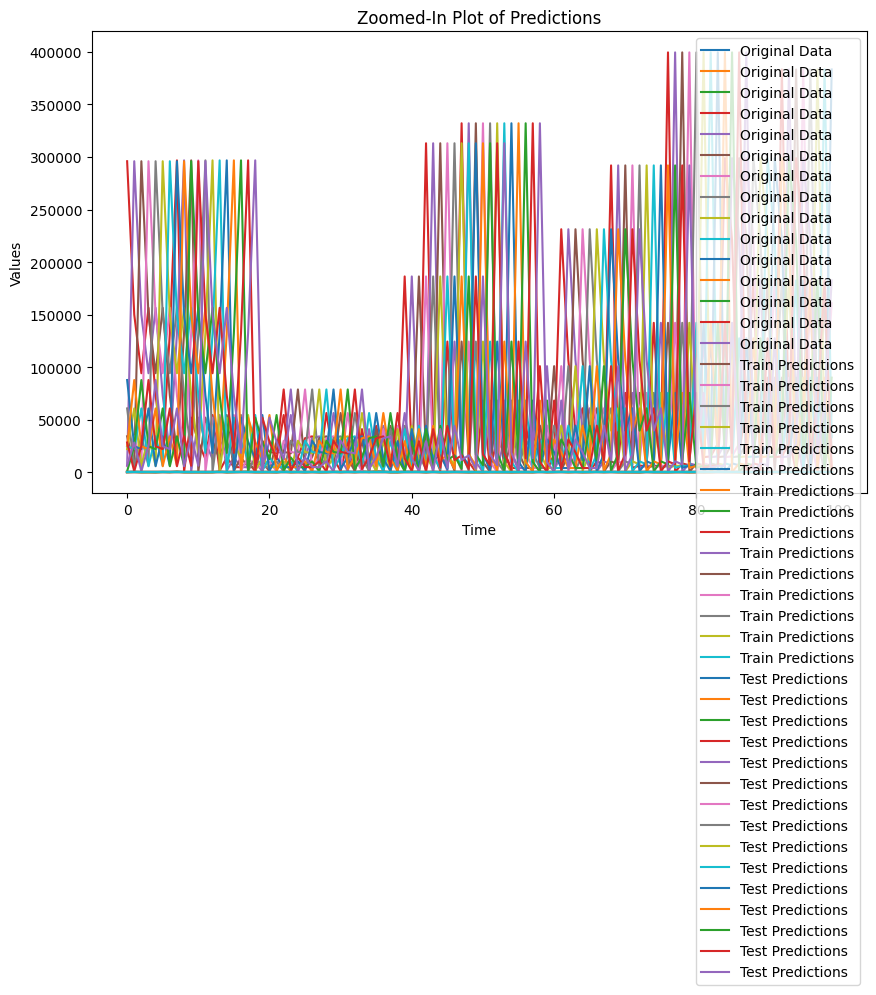

In [ ]:
### Plotting
# shift train predictions for plotting
# Define the range to zoom in
start_index = 1800
end_index = 1900  # Adjust as needed

# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict

# Plot baseline and predictions (zoomed-in)
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(scaled_data)[start_index:end_index], label='Original Data')
plt.plot(trainPredictPlot[start_index:end_index], label='Train Predictions')
plt.plot(testPredictPlot[start_index:end_index], label='Test Predictions')
plt.title('Zoomed-In Plot of Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

